In [78]:
#imports for PCA, ElasticNet, DecisionTree, GradientBoosting for regression
import time 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import math
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
# gaussian svr
from sklearn.svm import SVR
#LOO cross validation
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from scipy import stats
from scipy.stats import sem
import random
from xgboost import XGBRegressor

In [79]:
main_path= "D:/Year 4/HONS/Auto_QA_gestures/"
jerks_path = main_path + "Dataset/Appropriateness_Features/mean_jerk_values.csv"
XX_jerks = pd.read_csv(jerks_path) # With Spine joint and Name of "Cond/StudySeq"

accels_path =main_path +  "Dataset/Appropriateness_Features/mean_acceleration_values.csv"
XX_accels = pd.read_csv(accels_path) # With Spine joint and Name of "Cond/StudySeq"

pairwise_path =main_path +  "Dataset/Appropriateness_Features/mean_pairwise_joint_distances.csv"
XX_pairwise = pd.read_csv(pairwise_path) # With Spine joint and Name of "Cond/StudySeq"
XX_pairwise.drop(XX_pairwise.columns[range(1,15)], axis=1, inplace=True) # Without Spine Joint but with Name of "Cond/StudySeq"

rms_properties_path =main_path +  "Dataset/Appropriateness_Features/RMS_Energy_properties.csv"
XX_rms_energy_properties = pd.read_csv(rms_properties_path, index_col = False) # With Name of StudySeq

rms_distance_path =main_path +  "Dataset/Appropriateness_Features/RMS_Distance_scores_fd_scaled.csv"
XX_rms_distance_scores = pd.read_csv(rms_distance_path)
XX_rms_distance_scores.drop(XX_rms_distance_scores.columns[1], axis=1, inplace=True) # Dropping the Spine joint (always 0)

spectral_properties_path =main_path +  "Dataset/Appropriateness_Features/Mean_Spectral_Centroid_over_time.csv"
XX_spectral_properties = pd.read_csv(spectral_properties_path, index_col = False) 
print(XX_spectral_properties.columns)

msc_props_path = main_path + "Dataset/Appropriateness_Features/Mean_Spectral_Centroid_props.csv"
XX_msc_properties = pd.read_csv(msc_props_path, index_col = False)

mfcc_path =main_path +  "Dataset/Appropriateness_Features/Mean_MFCC_over_time.csv"
XX_mfcc = pd.read_csv(mfcc_path, index_col = False)

labels_path = main_path + "Dataset/Appropriateness_Labels/mean_opinion_scores.csv"
YY = pd.read_csv(labels_path) # # With Name of "Cond/StudySeq"
print(YY.columns)

Index(['Unnamed: 0', 'StudySeq', 'Mean_Spectral_Centroid1',
       'Mean_Spectral_Centroid2', 'Mean_Spectral_Centroid3',
       'Mean_Spectral_Centroid4', 'Mean_Spectral_Centroid5',
       'Mean_Spectral_Centroid6', 'Mean_Spectral_Centroid7',
       'Mean_Spectral_Centroid8', 'Mean_Spectral_Centroid9',
       'Mean_Spectral_Centroid10'],
      dtype='object')
Index(['Unnamed: 0', 'Mean_Appropriateness_Score'], dtype='object')


In [80]:
# Merging the features
XY = XX_jerks.join(YY, lsuffix="_jerks", rsuffix="_YY")
XY = XY.join(XX_accels, rsuffix='_accels')
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_accels'})
XY = XY.join(XX_pairwise, rsuffix='_pairwise')
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_pairwise'})
XY = XY.join(XX_rms_distance_scores)
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_rms_distance_scores'})
# Join the RMS Energy Properties Features
XY = XY.rename(columns={'Unnamed: 0_jerks': 'StudySeq'})
XY['StudySeq'] = XY['StudySeq'].apply(lambda x: x[8:])
XY = XY.join(XX_rms_energy_properties, rsuffix='_rms')
for i in range(1, int(XY.shape[0] / 40)):
    XY.iloc[i * 40:(i + 1) * 40, -5:] = XX_rms_energy_properties
#join the spectral properties
# #find overlapping columns between XY and XX_spectral_properties
# XY = XY.join(XX_spectral_properties, rsuffix='_spectral')
# #duplicate the spectral properties for each study sequence 
# for i in range(1, int(XY.shape[0] / 40)):
#     XY.iloc[i * 40:(i + 1) * 40, -12:] = XX_spectral_properties

#join the mfcc features
XY = XY.join(XX_mfcc, rsuffix='_mfcc')
#duplicate the mfcc features for each study sequence
for i in range(1, int(XY.shape[0] / 40)):
    XY.iloc[i * 40:(i + 1) * 40, -12:] = XX_mfcc
    
XY = XY.join(XX_msc_properties, rsuffix='_msc')
#duplicate the mfcc features for each study sequence
for i in range(1, int(XY.shape[0] / 40)):
    XY.iloc[i * 40:(i + 1) * 40, -5:] = XX_msc_properties


# Drop the Names of "Cond/StudySeq" and remaining information relating to the "Spine" joint
# Also Drop the Index from rms_energy
XY.drop(['Unnamed: 0_YY', 'Unnamed: 0_accels', 'Unnamed: 0_pairwise', 'Spine', 'Spine_accels',
         'Unnamed: 0_rms_distance_scores', 'Unnamed: 0', 'StudySeq_rms','Unnamed: 0_mfcc', 'StudySeq_mfcc', 'StudySeq_msc' , 'Unnamed: 0_msc' ], axis=1, inplace=True)

rename_dict = dict(zip(XY.columns[0:14], XY.columns[0:14] + '_jerks'))
XY = XY.rename(columns=rename_dict)

XY = XY.drop(['StudySeq_jerks'], axis=1, inplace=False)
# Jerk for 14 joints + Acceleration for 14 joints + 14 choose 2 pairwise distance + 14 RMS Energy Distance Scores + 3 RMS Energy Property Features + Label for MOS = 137
XX = XY.drop(['Mean_Appropriateness_Score'], axis=1, inplace=False)
#print row 35 to 45



In [81]:
XX = XY.drop(['Mean_Appropriateness_Score'], axis=1, inplace=False)
bad_features = ['LeftShoulder_vs_LeftArm', 'LeftArm_vs_LeftForeArm', 'LeftForeArm_vs_LeftHand',
                'RightShoulder_vs_RightArm', 'RightArm_vs_RightForeArm','RightForeArm_vs_RightHand']
XX.drop(bad_features, axis=1, inplace=True)
YY = XY.loc[:,'Mean_Appropriateness_Score']
# for i in range(1,11):
#     XX[f'Mean_Spectral_Centroid{i}'] = pd.to_numeric(XX[f'Mean_Spectral_Centroid{i}'], errors='coerce')
#     #find data type of Mean spectral centroid column
#     print(XX[f'Mean_Spectral_Centroid{i}'].head())
numeric_columns = XX.select_dtypes(include=[np.number]).columns.tolist()
print(numeric_columns)
#do log scaling of all features
# XX = np.log(XX)
XX.iloc[:,-17:-3] = XX.iloc[:,-17:-3]
print(XX.shape)
print(YY.shape)
print(XX.head())

['Spine1_jerks', 'Spine2_jerks', 'Spine3_jerks', 'LeftShoulder_jerks', 'LeftArm_jerks', 'LeftForearm_jerks', 'LeftHand_jerks', 'RightShoulder_jerks', 'RightArm_jerks', 'RightForearm_jerks', 'RightHand_jerks', 'Neck_jerks', 'Neck1_jerks', 'Head', 'Spine1_accels', 'Spine2_accels', 'Spine3_accels', 'LeftShoulder_accels', 'LeftArm_accels', 'LeftForearm_accels', 'LeftHand_accels', 'RightShoulder_accels', 'RightArm_accels', 'RightForearm_accels', 'RightHand_accels', 'Neck_accels', 'Neck1_accels', 'Head_accels', 'Spine1_vs_Spine2', 'Spine1_vs_Spine3', 'Spine1_vs_LeftShoulder', 'Spine1_vs_LeftArm', 'Spine1_vs_LeftForeArm', 'Spine1_vs_LeftHand', 'Spine1_vs_RightShoulder', 'Spine1_vs_RightArm', 'Spine1_vs_RightForeArm', 'Spine1_vs_RightHand', 'Spine1_vs_Neck', 'Spine1_vs_Neck1', 'Spine1_vs_Head', 'Spine2_vs_Spine3', 'Spine2_vs_LeftShoulder', 'Spine2_vs_LeftArm', 'Spine2_vs_LeftForeArm', 'Spine2_vs_LeftHand', 'Spine2_vs_RightShoulder', 'Spine2_vs_RightArm', 'Spine2_vs_RightForeArm', 'Spine2_vs_Ri

In [82]:
XX_train, XX_test, YY_train, YY_test = train_test_split(XX, YY, test_size=0.2, random_state=42)

In [83]:
print(type(XX_train))

<class 'pandas.core.frame.DataFrame'>


In [84]:
# Standardize the data
scaler = StandardScaler()
scaler.fit(XX_train)
XX_train = scaler.transform(XX_train)
XX_test = scaler.transform(XX_test)

In [75]:
#elastic net with feature selection
#remove nan values
# Create a list of alphas to cross-validate against

alphas = np.logspace(-5, 5, 100)

# Create a list of l1 ratio values to cross-validate against
l1_ratio = np.linspace(0.1, 0.9, 9)

# Create a dictionary of hyperparameters to search
param_grid = {'alpha': alphas, 'l1_ratio': l1_ratio}

# Create the GridSearchCV object
elastic_net = ElasticNet(alpha=1.0, l1_ratio=0.1, max_iter=1000, random_state=42)
elastic_net_cv = GridSearchCV(elastic_net, param_grid, cv=5)

# Fit it to the data
elastic_net_cv.fit(XX_train, YY_train)

# Print the tuned parameters and score
print("Tuned ElasticNet Parameters: {}".format(elastic_net_cv.best_params_))
print("Best score is {}".format(elastic_net_cv.best_score_))

y_pred = elastic_net_cv.predict(XX_test)
print("R^2: {}".format(elastic_net_cv.score(XX_test, YY_test)))
mse = mean_squared_error(YY_test, y_pred)
print("Mean Squared Error: {}".format(mse))

C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.228e+03, tolerance: 4.336e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.347e+03, tolerance: 3.851e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Tuned ElasticNet Parameters: {'alpha': 1.1233240329780265, 'l1_ratio': 0.1}
Best score is 0.29277670047077187
R^2: 0.19018314420761873
Mean Squared Error: 184.8709870670201


In [ ]:
#train elastic net and plot MSE over iterations
# Create the hyperparameter grid
l1_space = np.linspace(0, 1, 30)
alphas = np.logspace(-1, 1, 100)
param_grid = {'l1_ratio': l1_space, 'alpha': alphas}

# Instantiate the ElasticNet regressor: elastic_net
elastic_net = ElasticNet(max_iter=500)

# Setup the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(elastic_net, param_grid, cv=5)

# Fit it to the data
gm_cv.fit(XX_train, YY_train)

# Predict on the test set and compute metrics
y_pred = gm_cv.predict(XX_test)
r2 = gm_cv.score(XX_test, YY_test)
mse = mean_squared_error(YY_test, y_pred)
print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))

# Plot the l1 ratio
plt.plot(l1_space, gm_cv.cv_results_['mean_test_score'])
plt.xlabel('l1 ratio')
plt.ylabel('MSE')
plt.title('MSE over l1 ratio')
plt.show()

#plot the learning curve
# Create the figure and axes
fig, ax = plt.subplots()

# Plot the train and test MSE
ax.plot(gm_cv.cv_results_['param_l1_ratio'], gm_cv.cv_results_['mean_test_score'], label='Test MSE')

# Set the x-axis and y-axis labels
ax.set_xlabel('l1 ratio')
ax.set_ylabel('MSE')

# Show the legend
ax.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(gm_cv.best_estimator_.loss_curve_, label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Convergence Behavior')
plt.legend()
plt.show()

In [23]:
#create a decision tree regressor
# Create the hyperparameter grid

param_grid = {'max_depth': np.arange(2, 10)}

# Instantiate a Decision Tree regressor: tree
tree = DecisionTreeRegressor( random_state=42)

tree_cv = GridSearchCV(tree, param_grid, cv=5)

# Fit it to the data
tree_cv.fit(XX_train, YY_train)

# Predict on the test set and compute metrics
y_pred = tree_cv.predict(XX_test)
mse = mean_squared_error(YY_test, y_pred)
print("Tuned Decision Tree MSE: {}".format(mse))
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))

Tuned Decision Tree MSE: 140.82104481109252
Tuned Decision Tree Parameters: {'max_depth': 2}


Best parameters found:  {'n_estimators': 50}
Lowest RMSE found:  13.053372771172564
Tuned Gradient Boosting MSE: 150.68943115992352
Tuned Gradient Boosting Parameters: {'n_estimators': 50}


Text(0, 0.5, 'MSE')

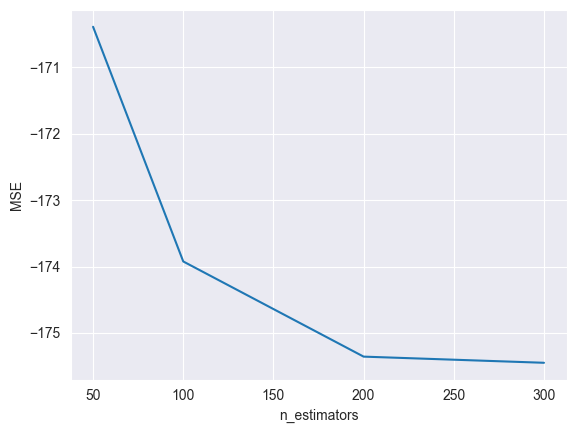

In [142]:
#train a gradient boosting regressor
# Create the hyperparameter grid
param_grid = {'n_estimators': [50,100,200,300]}

# Instantiate the regressor: gbrt
gbrt = GradientBoostingRegressor(max_depth=4, random_state=42, learning_rate=0.1)

# Perform grid search: grid_mse
grid_mse = GridSearchCV(gbrt, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit it to the data
grid_mse.fit(XX_train, YY_train)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

# Predict on the test set and compute metrics
y_pred = grid_mse.predict(XX_test)
mse = mean_squared_error(YY_test, y_pred)
print("Tuned Gradient Boosting MSE: {}".format(mse))
print("Tuned Gradient Boosting Parameters: {}".format(grid_mse.best_params_))

#plot the learning curve
# Create the figure and axes
fig, ax = plt.subplots()

# Plot the train and test MSE
ax.plot(grid_mse.cv_results_['param_n_estimators'], grid_mse.cv_results_['mean_test_score'], label='Test MSE')

# Set the x-axis and y-axis labels
ax.set_xlabel('n_estimators')
ax.set_ylabel('MSE')


Tuned SVR MSE: 189.83002294417727
Tuned SVR Parameters: {'C': 10.0, 'gamma': 0.001}


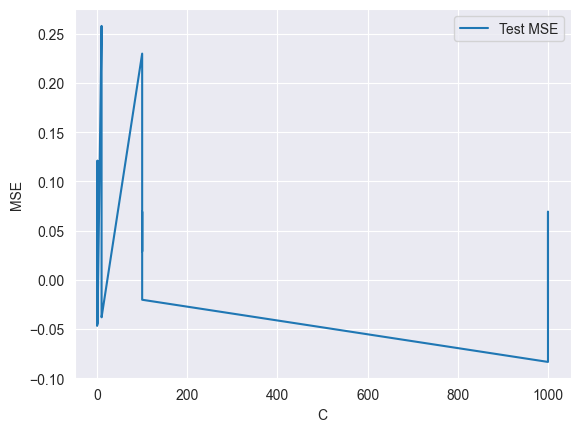

In [139]:
#train gaussian svr
# Create the hyperparameter grid
param_grid = {'C': np.logspace(-3, 3, 7), 'gamma': np.logspace(-3, 3, 7)}

# Instantiate a Gaussian SVR regressor: svr
svr = SVR()

# Instantiate the GridSearchCV object: svr_cv
svr_cv = GridSearchCV(svr, param_grid, cv=5)

# Fit it to the data
svr_cv.fit(XX_train, YY_train)
    
# Predict on the test set and compute metrics
y_pred = svr_cv.predict(XX_test)
mse = mean_squared_error(YY_test, y_pred)
print("Tuned SVR MSE: {}".format(mse))
print("Tuned SVR Parameters: {}".format(svr_cv.best_params_))

#make plots of the learning curve
# Create the figure and axes
fig, ax = plt.subplots()

# Plot the train and test MSE
ax.plot(svr_cv.cv_results_['param_C'], svr_cv.cv_results_['mean_test_score'], label='Test MSE')
#plot train mse
ax.plot(svr_cv.cv_results_['param_C'], svr_cv.cv_results_['mean_train_score'], label='Train MSE')

# Set the x-axis and y-axis labels
ax.set_xlabel('C')
ax.set_ylabel('MSE')

# Show the legend
ax.legend()
plt.show()


In [24]:
def learning_curve(model_name, model, XX, YY, param_grid, xticks, log_bool):
    n_splits = 5
    outer_loop_cv = KFold(n_splits = n_splits, shuffle = True)
    outer_val_mse = []
    outer_train_mse = []
    folds = outer_loop_cv.split(XX)
    count = 1
    for train, test in folds:
        XX_train = XX.iloc[train]
        YY_train = YY.iloc[train]
        
        inner_val_scores = []
        inner_train_scores = []
        for train_set_size in param_grid:
            val_scores = []
            train_scores = []
            inner_loop_cv = KFold(n_splits = n_splits, shuffle = True)
            inner_folds = inner_loop_cv.split(XX_train)
            for inner_train, val in inner_folds: # cross validation for the given train set size with the given train set
                train_indexes = random.sample(inner_train.tolist(), int(train_set_size))
                XX_train_reduced = XX_train.iloc[train_indexes]
                YY_train_reduced = YY_train.iloc[train_indexes]
                XX_val = XX_train.iloc[val]
                YY_val = YY_train.iloc[val]
                
                YY_train_reduced = YY_train_reduced.values.flatten()
                YY_val = YY_val.values.flatten()
                
                model.fit(XX_train_reduced, YY_train_reduced)
                val_scores = val_scores + [mean_squared_error(YY_val, np.clip(model.predict(XX_val), 0, 100), squared=True)]
                train_scores = train_scores + [mean_squared_error(YY_train_reduced, 
                                                                  np.clip(model.predict(XX_train_reduced), 0, 100),
                                                                  squared=True)]
            inner_val_scores = inner_val_scores + [np.mean(val_scores)]
            inner_train_scores = inner_train_scores + [np.mean(train_scores)]
        outer_val_mse = outer_val_mse + [inner_val_scores]
        outer_train_mse = outer_train_mse + [inner_train_scores]
        print('Fold ', count, '/', n_splits, ' Complete.')
        count = count + 1
        
    mean_val_mse = np.mean(np.asarray(outer_val_mse), axis=0)
    mean_train_mse = np.mean(np.asarray(outer_train_mse), axis=0)

    plt.figure(figsize=(6,4))
    plt.plot(param_grid, mean_train_mse, label='MSE on Training Set')
    plt.plot(param_grid, mean_val_mse, label='MSE on Validation Set')
    plt.xlim(min(param_grid), max(param_grid))
    if (log_bool == False):
        plt.xticks(xticks)
    if (log_bool == True):
        plt.xscale('log')
    plt.ylim(0, max(mean_val_mse) + max(mean_val_mse)*0.05)
    plt.ylabel('MSE')
    plt.xlabel('Number of Observations in the Training Set')
    plt.title(model_name + ' performance\n on different Training Set sizes')
    plt.legend()
    
    print('Best Training Set Size: ', int(param_grid[np.where(mean_val_mse == (min(mean_val_mse)))[0]]))

In [25]:
def validation_curve(model_name, model, XX, YY, param_grid, log_bool, extra_string, xticks):
    n_splits = 5
    outer_loop_cv = KFold(n_splits = n_splits, shuffle = True)
    outer_val_mse = []
    outer_train_mse = []
    folds = outer_loop_cv.split(XX)
    count = 1
    for train, test in folds:
        XX_train = XX.iloc[train]
        YY_train = YY.iloc[train]
        YY_train = YY_train.values.flatten()
        
        cv_model = GridSearchCV(estimator = model, param_grid = param_grid, scoring = "neg_mean_squared_error", 
                                    cv = KFold(n_splits = 5, shuffle = True), return_train_score=True)
        cv_model.fit(XX_train, YY_train)
        
        train_mse = -1 * cv_model.cv_results_["mean_train_score"]
        val_mse = -1 * cv_model.cv_results_["mean_test_score"]
        
        outer_train_mse = outer_train_mse + [train_mse]
        outer_val_mse = outer_val_mse + [val_mse]
        print('Fold ', count, '/', n_splits, ' Complete.')
        count = count + 1
        
    mean_train_mse = np.mean(np.asarray(outer_train_mse), axis=0)
    mean_val_mse = np.mean(np.asarray(outer_val_mse), axis=0)
    
    train_mse_sem = sem(np.asarray(outer_train_mse), axis=0)
    val_mse_sem = sem(np.asarray(outer_val_mse), axis=0)
    
    param_list = list(np.concatenate(list(param_grid.values())).flat)
    
    plt.figure(figsize = (6,4))
    plt.plot(param_list, mean_train_mse, label='Training Set MSE')
    plt.fill_between(param_list, mean_train_mse - train_mse_sem, mean_train_mse + train_mse_sem, alpha=0.5)
    plt.plot(param_list, mean_val_mse, label='Validation Set MSE')
    plt.fill_between(param_list, mean_val_mse - val_mse_sem, mean_val_mse + val_mse_sem, alpha=0.5)
    if log_bool == True:
        plt.xscale('log')
    plt.xlim(min(param_list),max(param_list))
    plt.xticks(xticks)
    plt.ylim(0, max([max(mean_train_mse), max(mean_val_mse)]) + max([max(train_mse_sem), max(val_mse_sem)]))
    plt.ylabel('MSE')
    plt.xlabel(list(param_grid.keys())[0])
    plt.title(model_name + ' performance on varying ' + list(param_grid.keys())[0] + extra_string)
    plt.legend()
    

In [26]:
# Model name is just the type of algorithm e.g. Linear Regression or kNN
def predicted_vs_true(model_name, model, XX, YY):
    n_splits = 5
    outer_loop_cv = KFold(n_splits = n_splits, shuffle = True)
    folds = outer_loop_cv.split(XX)
    count = 1
    YY_train_true = []
    YY_train_preds = []
    YY_preds = []
    YY_true = []
    for train, test in folds:
        XX_train = XX.iloc[train]
        YY_train = YY.iloc[train]
        XX_test= XX.iloc[test]
        YY_test = YY.iloc[test]
        YY_train, YY_test = YY_train.values.flatten(), YY_test.values.flatten()
        
        model.fit(XX_train, YY_train)
        
        YY_train_preds = YY_train_preds + list(model.predict(XX_train))
        YY_train_true = YY_train_true + list(YY_train)
        
        YY_pred = model.predict(XX_test)
        
        YY_true = YY_true + list(YY_test)
        YY_preds = YY_preds + list(YY_pred)
        print('Fold ', count, '/', n_splits, ' Complete.')
        count = count + 1
    
    
    m, b = np.polyfit(YY_preds, YY_true, 1)
    x = np.arange(0,101)
    y = np.arange(0,101)
    
    plt.figure(figsize = (7,7))
    plt.scatter(YY_preds, YY_true, s=7.5, alpha=0.8, label='Predictions')
    plt.plot(x, y*m + b, '-c', label="Regression Line for predictions")
    plt.plot(x, y, "-k", label="Regression Line for p=1", alpha=0.5)
    plt.title("Predictions of " + model_name + " Model on Test Set")
    plt.ylabel("True Appropriateness")
    plt.xlabel("Predicted Appropriateness")
    plt.xticks(np.linspace(0,100,11))
    plt.yticks(np.linspace(0,100,11))
    plt.xlim(0,100)
    plt.ylim(0,100)
    plt.legend()

    rho, pval = stats.spearmanr(YY_true, YY_preds)
    print("Pearson Correlation Coefficient =", rho)
    print("Test Mean Squared Error = ", mean_squared_error(YY_true, YY_preds, squared=True))
    print("Train Mean Squared Error = ", mean_squared_error(YY_train_true, YY_train_preds, squared=True))

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Best Training Set Size:  211
Time taken:  48.18242311477661


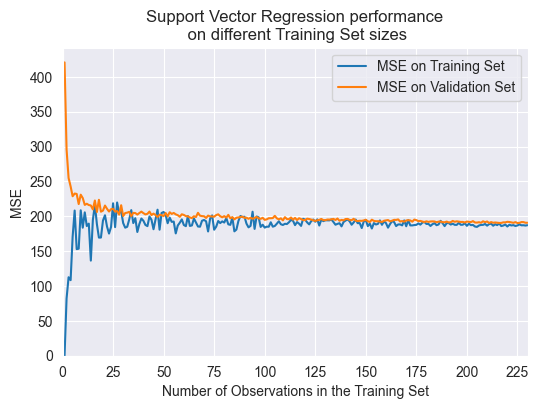

In [149]:
start_time = time.time()
svr = SVR(kernel = "rbf", cache_size=7000)
# No hyperparameter tuning since it would take far too long
learning_curve('Support Vector Regression', svr, XX, YY, np.linspace(1,230,230), np.linspace(0,225,10), False)
print("Time taken: ", time.time() - start_time)

C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.012e+04, tolerance: 4.350e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.329e+03, tolerance: 3.766e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Fold  1 / 5  Complete.


C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.615e+03, tolerance: 4.688e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.509e+03, tolerance: 4.068e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Fold  2 / 5  Complete.


C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.010e+03, tolerance: 4.694e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.010e+03, tolerance: 4.387e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Fold  3 / 5  Complete.


C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.716e+03, tolerance: 4.628e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.103e+03, tolerance: 4.938e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Fold  4 / 5  Complete.


C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.860e+03, tolerance: 4.953e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.566e+03, tolerance: 5.270e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Fold  5 / 5  Complete.
Time taken:  40.34933805465698


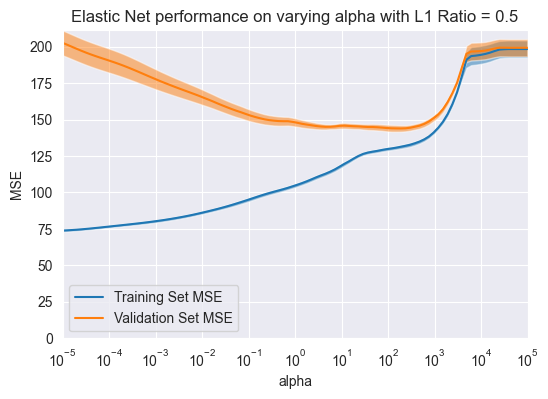

In [151]:
start_time = time.time()
elastic_net = ElasticNet(max_iter=1000, random_state=42) 
param_grid1 = {'alpha': np.logspace(-5, 5, 100)}
validation_curve('Elastic Net', elastic_net, XX, YY, param_grid1, True, " with L1 Ratio = 0.5", np.logspace(-5, 5, 11))
print("Time taken: ", time.time() - start_time)

In [152]:
#grid search to find best hyperparameters for elastic net
# Create the hyperparameter grid
param_grid = {'alpha': np.logspace(-5, 5, 100), 'l1_ratio': np.linspace(0.1, 0.9, 9)}

# Instantiate the ElasticNet regressor: elastic_net
elastic_net = ElasticNet(max_iter=1000, random_state=42)

# Instantiate the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(elastic_net, param_grid, cv=5)

# Fit it to the data
gm_cv.fit(XX_train, YY_train)

# Predict on the test set and compute metrics
y_pred = gm_cv.predict(XX_test)
r2 = gm_cv.score(XX_test, YY_test)
mse = mean_squared_error(YY_test, y_pred)
print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))


C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.248e+03, tolerance: 4.336e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.359e+03, tolerance: 3.851e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Tuned ElasticNet l1 ratio: {'alpha': 0.8902150854450392, 'l1_ratio': 0.1}
Tuned ElasticNet R squared: 0.19405494970834536
Tuned ElasticNet MSE: 183.98710264360875


In [27]:
#run elastic net with alpha = 100.0 and l1_ratio = 0.1
elastic_net = ElasticNet(alpha=0.9, l1_ratio=0.1, max_iter=1000, random_state=42)
elastic_net.fit(XX_train, YY_train)
y_pred = elastic_net.predict(XX_test)
print("R^2: {}".format(elastic_net.score(XX_test, YY_test)))
mse = mean_squared_error(YY_test, y_pred)
print("Mean Squared Error: {}".format(mse))


R^2: 0.20367935659199266
Mean Squared Error: 181.78997178891257


C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.241e+04, tolerance: 4.804e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.227e+04, tolerance: 4.417e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Fold  1 / 5  Complete.


C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.257e+04, tolerance: 4.818e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.157e+04, tolerance: 4.177e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Fold  2 / 5  Complete.


C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.080e+04, tolerance: 4.812e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.273e+04, tolerance: 4.747e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Fold  3 / 5  Complete.


C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.082e+04, tolerance: 4.609e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.289e+04, tolerance: 4.700e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Fold  4 / 5  Complete.


C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.101e+04, tolerance: 4.612e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.324e+04, tolerance: 4.655e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Fold  5 / 5  Complete.
Time taken:  3.538412094116211


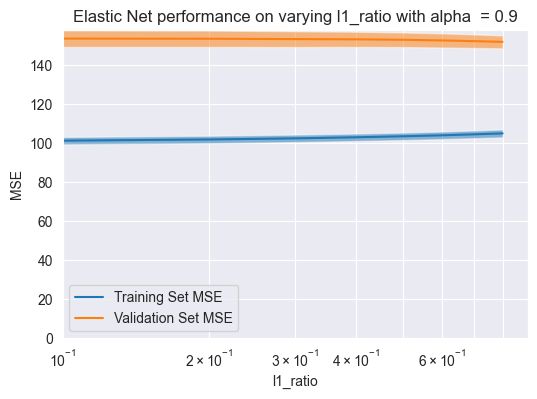

In [157]:
start_time = time.time()
elastic_net = ElasticNet(max_iter=1000, random_state=42, alpha=0.9) 
param_grid1 = {'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]}
validation_curve('Elastic Net', elastic_net, XX, YY, param_grid1, True, " with alpha  = 0.9", np.linspace(0.1, 0.9, 9))
print("Time taken: ", time.time() - start_time)

C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.606e+04, tolerance: 5.360e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.448e+04, tolerance: 5.666e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.5156318530760842
Test Mean Squared Error =  162.85688487299353
Train Mean Squared Error =  101.63740737208035
Time taken:  0.1536397933959961


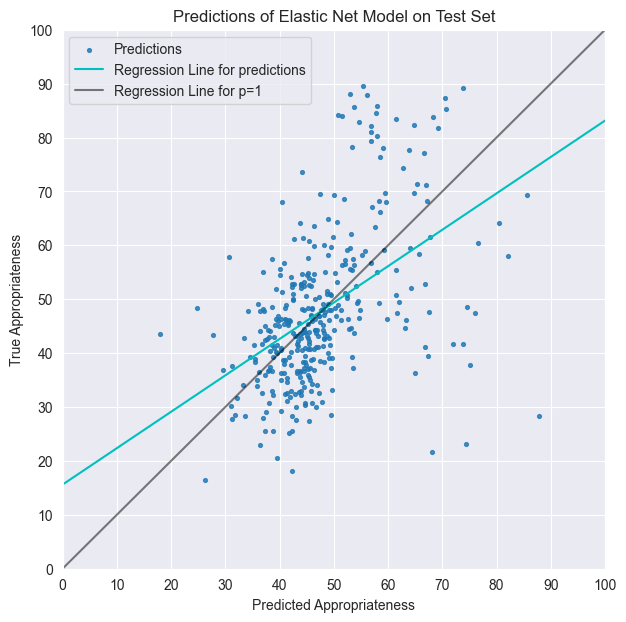

In [28]:
start_time = time.time()
kfolds = KFold(n_splits = 5, shuffle = True)
param_grid = {'alpha': np.logspace(-5, 5, 100), 'l1_ratio': np.linspace(0.1, 0.9, 9)}
elastic_net = ElasticNet(max_iter=1000, random_state=42)
elastic_net_cv = GridSearchCV(estimator=elastic_net, param_grid=param_grid, cv=kfolds, scoring='neg_mean_squared_error')
predicted_vs_true('Elastic Net', elastic_net, XX, YY)
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  4.744297742843628


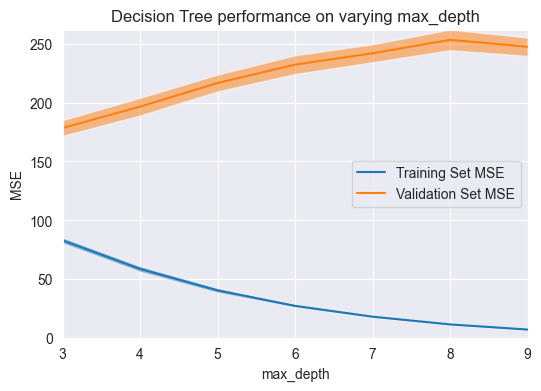

In [29]:
start_time = time.time()
#param grid for decision tree
param_grid = {'max_depth': np.arange(3, 10)}
tree = DecisionTreeRegressor(random_state=42)
validation_curve('Decision Tree', tree, XX, YY, param_grid, False, "", np.arange(3, 10))
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.35317495269996213
Test Mean Squared Error =  165.95940108834148
Train Mean Squared Error =  87.80822561655621
Time taken:  4.4650559425354


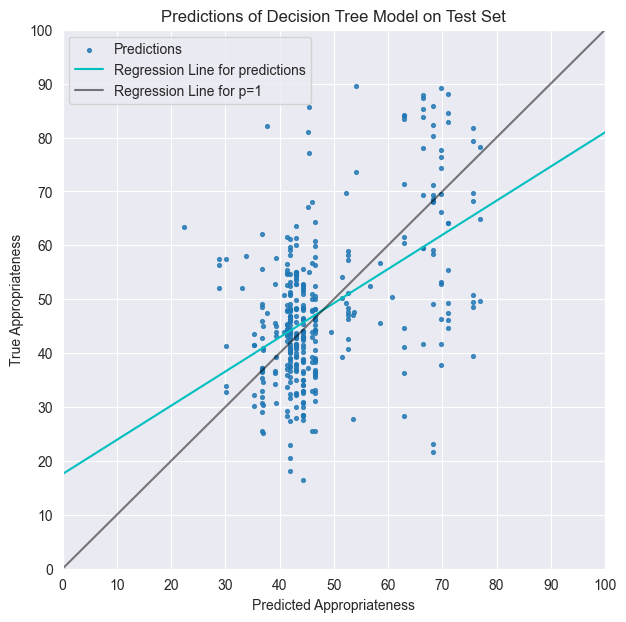

In [30]:
start_time = time.time()
#param grid for decision tree
param_grid = {'max_depth': np.arange(3, 10)}
k_folds = KFold(n_splits = 5, shuffle = True)
tree = DecisionTreeRegressor(random_state=42)
tree_cv = GridSearchCV(estimator=tree, param_grid=param_grid, cv=k_folds, scoring='neg_mean_squared_error')
predicted_vs_true('Decision Tree', tree_cv, XX, YY)
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  409.0784287452698


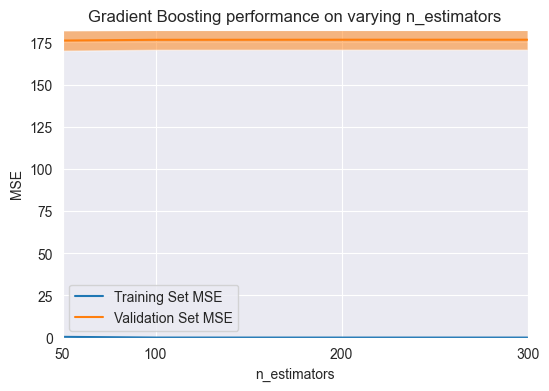

In [167]:
start_time = time.time()
#param grid for gradient boosting
param_grid = {'n_estimators': [50,100,200,300]}
gbrt = GradientBoostingRegressor(max_depth=3, random_state=42)
validation_curve('Gradient Boosting', gbrt, XX, YY, param_grid, False, "", [50,100,200,300])
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.5706880080702272
Test Mean Squared Error =  142.47821070972688
Train Mean Squared Error =  9.737456318466258
Time taken:  263.8514144420624


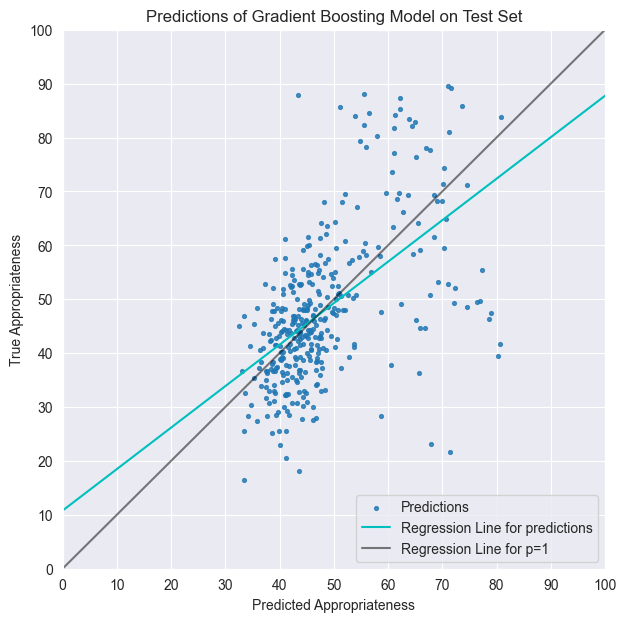

In [31]:
start_time = time.time()
#param grid for gradient boosting
param_grid = {'n_estimators': [50,100,200,300]}
k_folds = KFold(n_splits = 5, shuffle = True)
gbrt = GradientBoostingRegressor(max_depth=4, random_state=42)
gbrt_cv = GridSearchCV(estimator=gbrt, param_grid=param_grid, cv=k_folds, scoring='neg_mean_squared_error')
predicted_vs_true('Gradient Boosting', gbrt_cv, XX, YY)
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.5266083182559853
Test Mean Squared Error =  163.68425255460244
Train Mean Squared Error =  4.1164179417458024


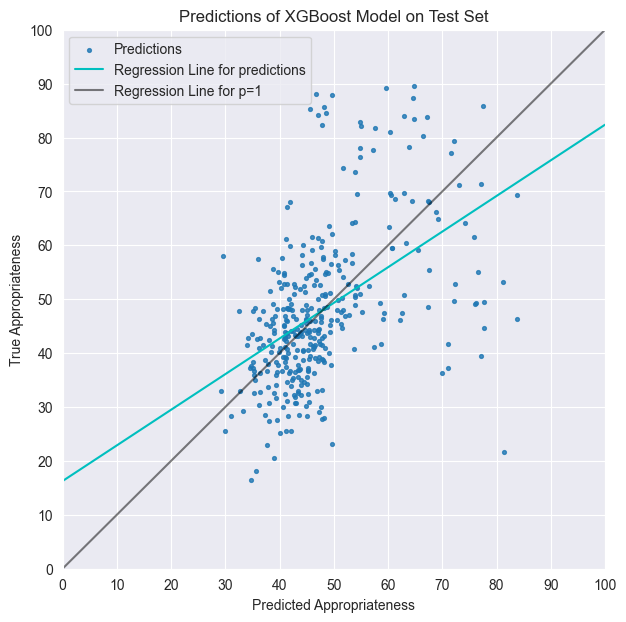

In [86]:
#create XGBoost regressor
#create param grid
param_grid = {'n_estimators': [10,20,30,40,50,100,200,300,500]}
xg_reg = XGBRegressor()
kfolds = KFold(n_splits = 5, shuffle = True)
# Perform grid search: grid_mse
grid_mse = GridSearchCV(xg_reg, param_grid, cv=kfolds, scoring='neg_mean_squared_error')

predicted_vs_true('XGBoost', grid_mse, XX, YY)

# # Fit it to the data
# grid_mse.fit(XX_train, YY_train)
# 
# # Print the best parameters and lowest RMSE
# print("Best parameters found: ", grid_mse.best_params_)
# print("Lowest RMSE found: ", grid_mse.best_score_)
#       
# # Predict on the test set and compute metrics
# y_pred = grid_mse.predict(XX_test)
# mse = mean_squared_error(YY_test, y_pred)
# print("Tuned XGBoost MSE: {}".format(mse))



Tuned XGBoost MSE: 172.1318731200412


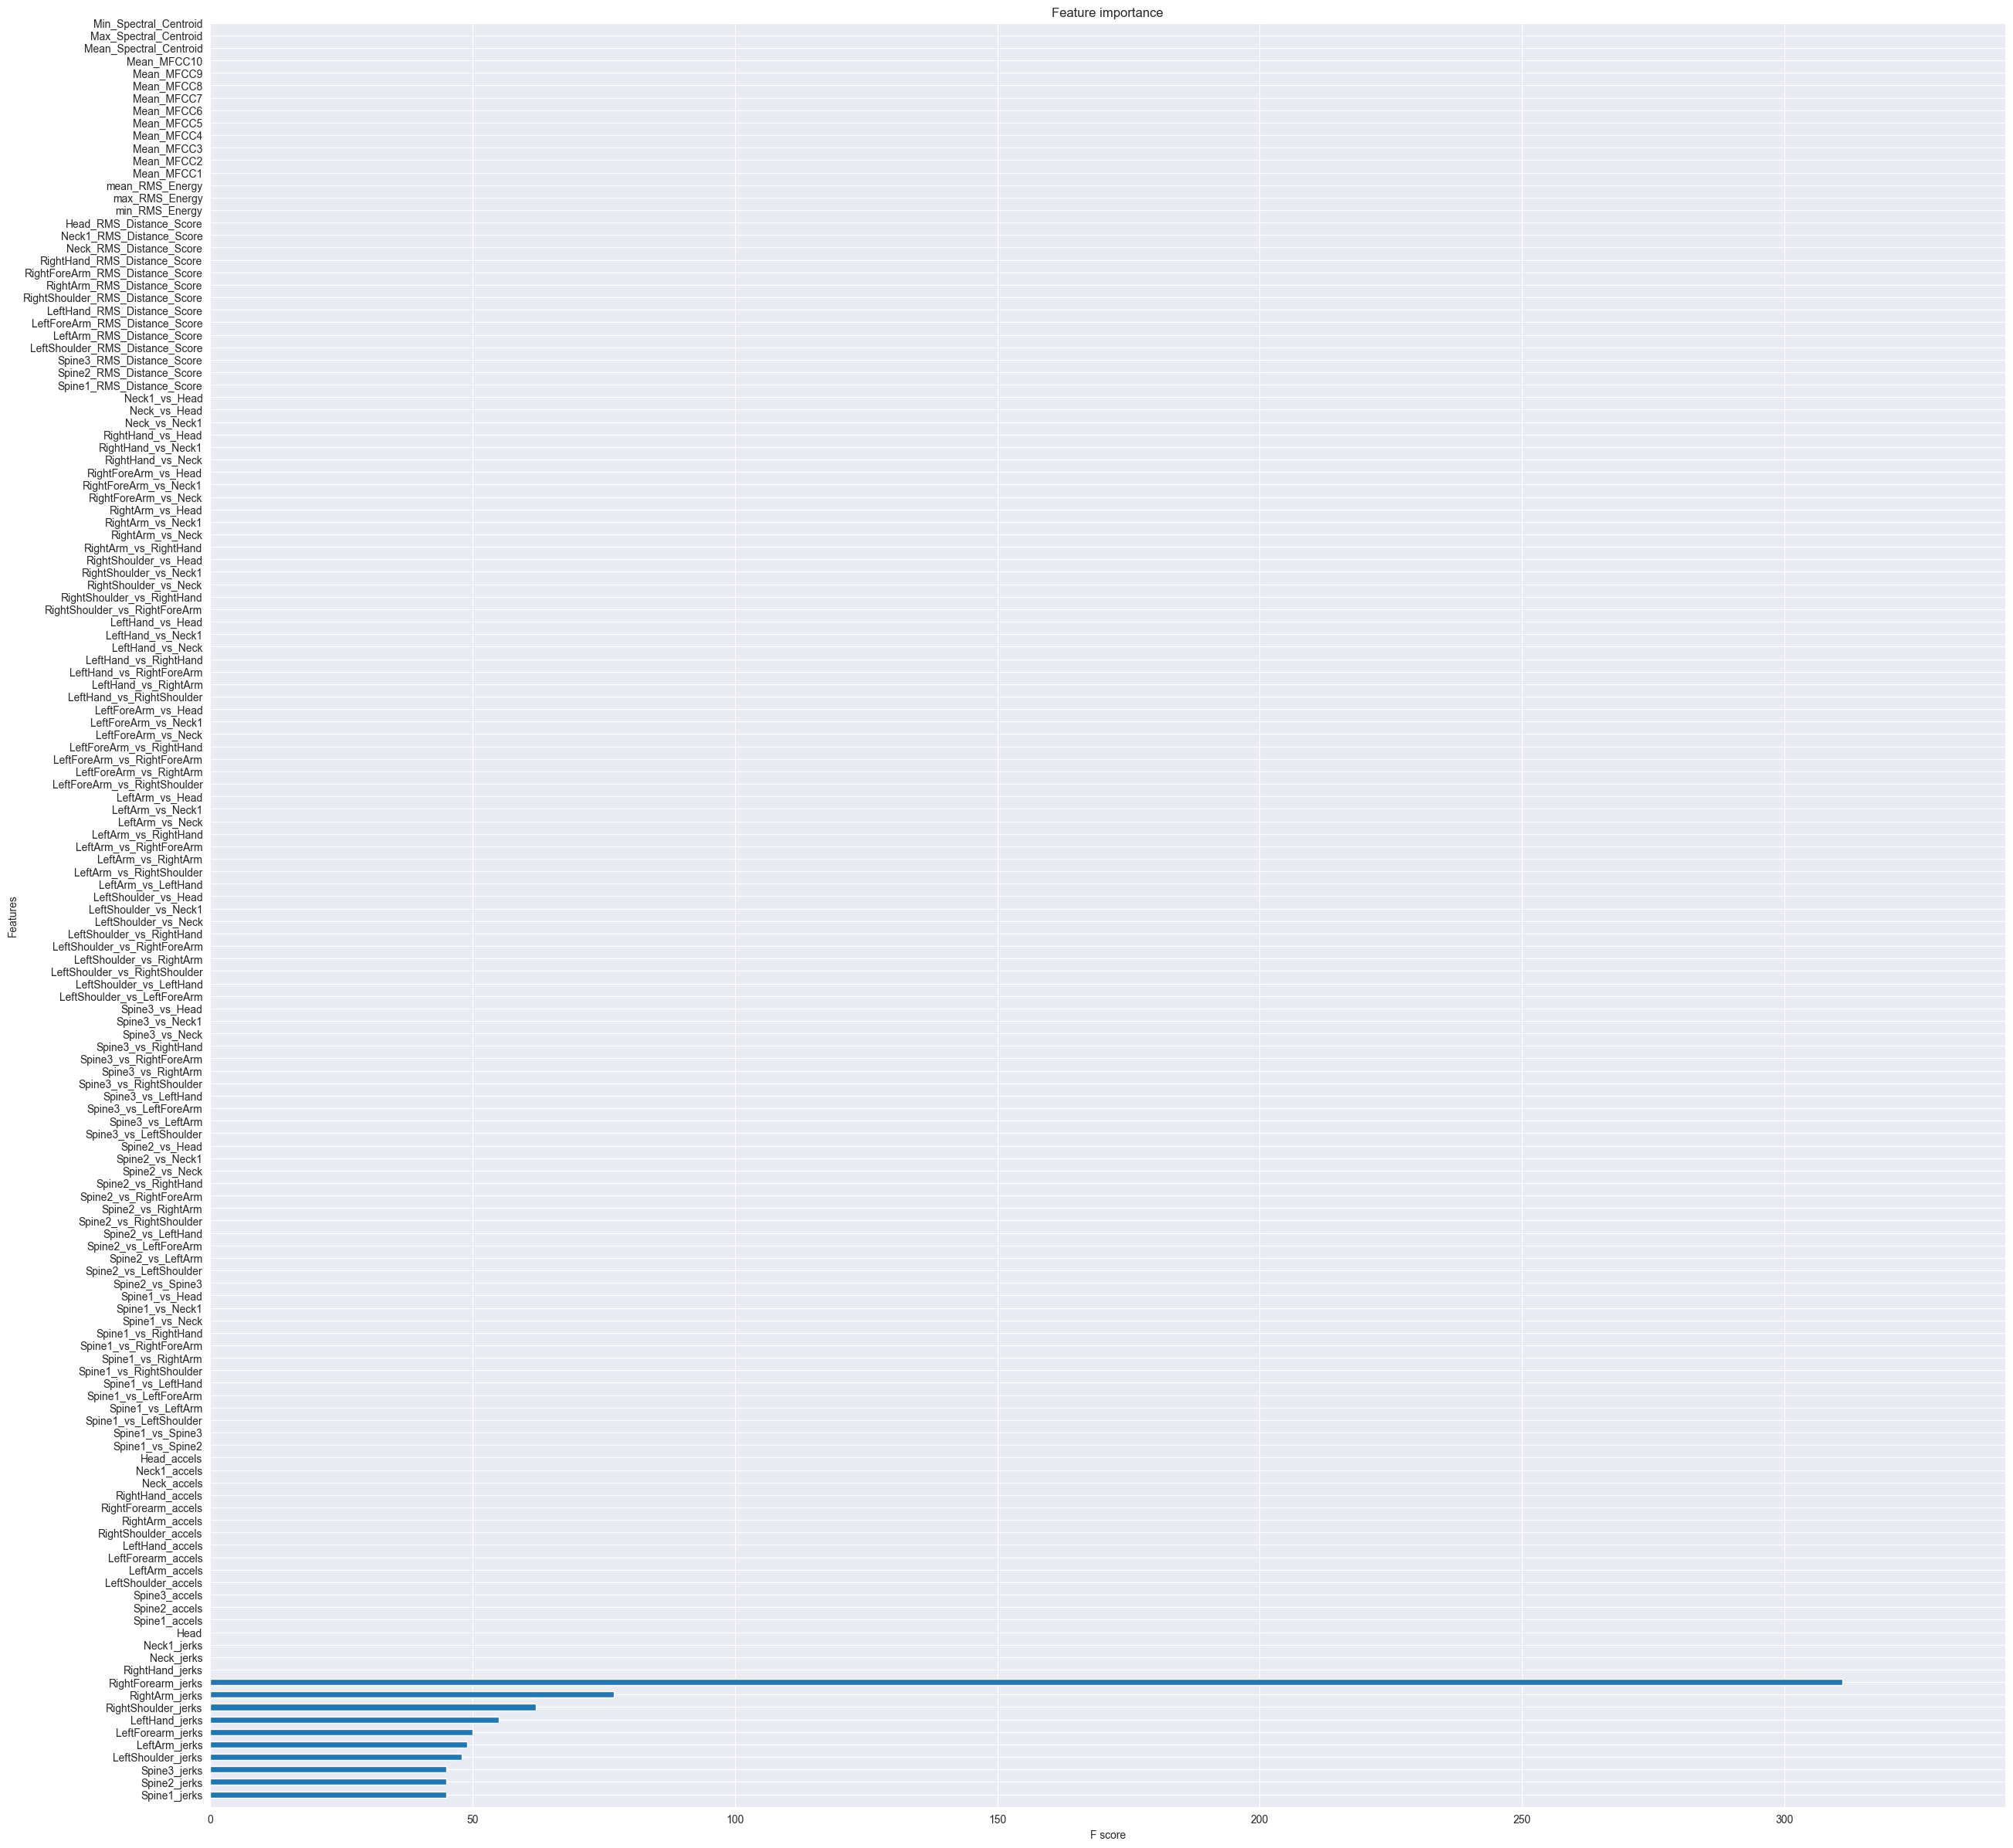

In [85]:
from xgboost import plot_importance

param_grid = {'n_estimators': np.arange(50, 300, 50)}

# Instantiate a xgboost regressor: xgb
xgb_cv = XGBRegressor(random_state=42, max_depth=6)

# Instantiate the GridSearchCV object: xgb_cv
# xgb_cv = GridSearchCV(xgb, param_grid, cv=5)

# Fit it to the data
xgb_cv.fit(XX_train, YY_train)

# Predict on the test set and compute metrics
y_pred = xgb_cv.predict(XX_test)
mse = mean_squared_error(YY_test, y_pred)
print("Tuned XGBoost MSE: {}".format(mse))
# print("Tuned XGBoost Parameters: {}".format(xgb_cv.best_params_))
#print top 10 most important features
# plot_importance(xgb_cv, height=0.1, max_num_features=10)
#increase the size of the plot
feature_names = XX.columns

plot_importance(xgb_cv, importance_type='weight', show_values=False, max_num_features=10, height=0.5)
plt.rcParams['figure.figsize'] = [30, 30]
plt.yticks(range(len(feature_names)), feature_names)
plt.show()

In [67]:
pcc_vals = []
for i in XX.columns:
    rho, pval = stats.spearmanr(XX[i], YY)
    if (math.isnan(rho)):
        rho = 0
    pcc_vals = pcc_vals + [rho]

abs_pcc_vals = np.abs(pcc_vals)
sorted_abs_pcc_vals = np.sort(abs_pcc_vals)

sorted_features = []
for i in sorted_abs_pcc_vals:
    feature_index = np.where(abs_pcc_vals == i)
    sorted_features = sorted_features + [XX.columns[feature_index]]

print("Feature with Highest Correlation: ", sorted_features[-1][0], " - PCC =", pcc_vals[np.where(XX.columns == sorted_features[-1][0])[0][0]])
print("Feature with 2nd Highest Correlation: ", sorted_features[-2][0], " - PCC =", pcc_vals[np.where(XX.columns == sorted_features[-2][0])[0][0]])
print("Feature with 3rd Highest Correlation: ", sorted_features[-3][0], " - PCC =", pcc_vals[np.where(XX.columns == sorted_features[-3][0])[0][0]])
print("Feature with 3rd Lowest Correlation: ", sorted_features[2][0], " - PCC =", pcc_vals[np.where(XX.columns == sorted_features[2][0])[0][0]])
print("Feature with 2nd Lowest Correlation: ", sorted_features[1][0], " - PCC =", pcc_vals[np.where(XX.columns == sorted_features[1][0])[0][0]])
print("Feature with Lowest Correlation: ", sorted_features[0][0], " - PCC =", pcc_vals[np.where(XX.columns == sorted_features[0][0])[0][0]])

for i in range (-20,0):
    print("Feature with ", -i, "th Highest Correlation: ", sorted_features[i][0], " - PCC =", pcc_vals[np.where(XX.columns == sorted_features[i][0])[0][0]])

print("Mean Feature PCC (absolute): ", np.mean(sorted_abs_pcc_vals), "with stdev: ", np.std(sorted_abs_pcc_vals))

Feature with Highest Correlation:  Spine1_accels  - PCC = 0.3640844127644673
Feature with 2nd Highest Correlation:  Spine2_accels  - PCC = 0.3534751392534913
Feature with 3rd Highest Correlation:  Spine1_jerks  - PCC = 0.3247373659213308
Feature with 3rd Lowest Correlation:  Mean_MFCC10  - PCC = -0.0026570929396645313
Feature with 2nd Lowest Correlation:  LeftArm_vs_LeftHand  - PCC = 0.0012214611417051596
Feature with Lowest Correlation:  LeftHand_vs_Neck1  - PCC = 0.0011596036128401163
Feature with  20 th Highest Correlation:  Spine2_jerks  - PCC = 0.23748995779677498
Feature with  19 th Highest Correlation:  Neck_accels  - PCC = 0.23917760093876242
Feature with  18 th Highest Correlation:  Spine2_vs_LeftForeArm  - PCC = -0.241316379655092
Feature with  17 th Highest Correlation:  LeftShoulder_vs_Neck  - PCC = 0.2464306033500741
Feature with  16 th Highest Correlation:  Spine3_vs_LeftForeArm  - PCC = -0.24662236673085672
Feature with  15 th Highest Correlation:  RightShoulder_vs_Neck 